# Nuovi Decessi e Terapie Intensive

Correlazione tra nuovi deceduti e terapie intensive.

> Max Pierini

In [1]:
import random
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import dates as mdates
import matplotlib.gridspec as gridspec
import statsmodels.api as sm

from IPython.display import Markdown

In [2]:
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    index_col='data', parse_dates=['data']
).sort_values('data')

In [4]:
df['nuovi_deceduti'] = df.deceduti.diff()

In [5]:
df['dec_int_rate'] = df.nuovi_deceduti / df.terapia_intensiva

In [6]:
df['dec_int_rate_filtered'] = df.dec_int_rate

Rapporto grezzo nuovi deceduti su terapie intensive:

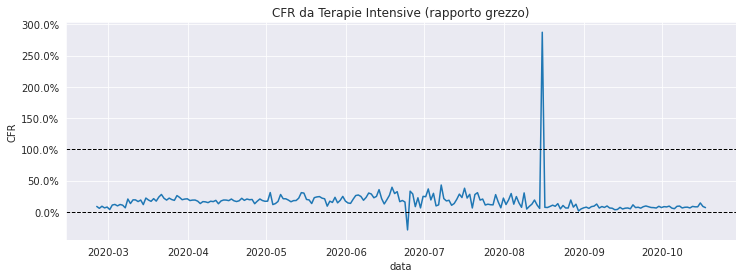

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(
    data=df,
    x='data', y='dec_int_rate',
    ax=ax
)
ax.axhline(0, ls='--', lw=1, color='k')
ax.axhline(1, ls='--', lw=1, color='k')
ax.set(
    ylabel='CFR',
    title='CFR da Terapie Intensive (rapporto grezzo)'
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
plt.show()

Definizione e rimozione outliers (minori di 0% e maggiori di 100%)

In [8]:
outliers = ((df.dec_int_rate > 1) | (df.dec_int_rate < 0)).values.nonzero()
for outlier in outliers:
    for idx in outlier:
        print(f"{df.index[idx]}: {df.dec_int_rate[idx]:.2%}")
        df.at[df.index[idx], 'dec_int_rate_filtered'] = df.iloc[idx-1]['dec_int_rate_filtered']

2020-06-24 17:00:00: -28.97%
2020-08-15 17:00:00: 287.27%


Fit su polinomio di ottavo grado

In [9]:
params = np.polyfit(
    np.array(range(df.index.size))[1:], df.dec_int_rate_filtered.values[1:], 8
)
func = np.poly1d(params)
fitted = func(np.array(range(df.index.size))[1:])

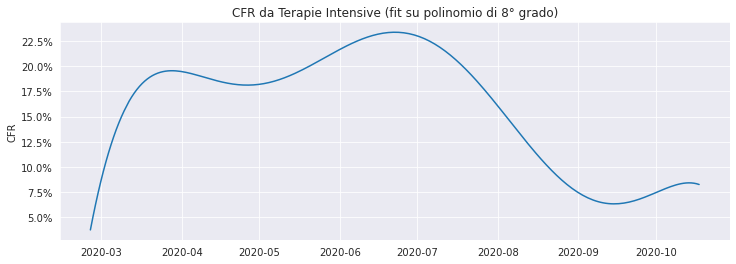

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index[1:], fitted)
ax.set(
    ylabel='CFR',
    title='CFR da Terapie Intensive (fit su polinomio di 8° grado)'
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
plt.show();

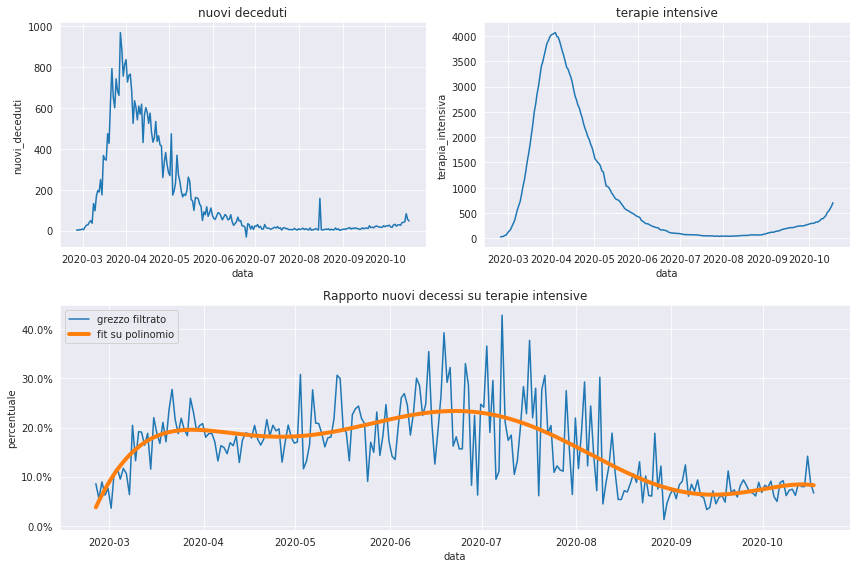

In [11]:
fig = plt.figure(tight_layout=True, figsize=(12, 8))
gs = gridspec.GridSpec(2, 2)

ax_sn = fig.add_subplot(gs[0, 0])
sns.lineplot(data=df, x='data', y='nuovi_deceduti', ax=ax_sn)
ax_sn.set_title('nuovi deceduti')

ax_dx = fig.add_subplot(gs[0, 1])
sns.lineplot(data=df, x='data', y='terapia_intensiva', ax=ax_dx)
ax_dx.set_title('terapie intensive')

ax = fig.add_subplot(gs[1, :])
sns.lineplot(
    data=df,
    x='data', y='dec_int_rate_filtered', 
    label='grezzo filtrato',
    ax=ax
)
ax.plot(df.index[1:], fitted, lw=4, label='fit su polinomio')
ax.legend(loc='upper left')
ax.set_ylabel('percentuale')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
ax.set_title('Rapporto nuovi decessi su terapie intensive')
plt.show()

Correlazione sulla linea temporale

In [12]:
df['mese'] = df.index.month_name()

In [13]:
df['mese_num'] = df.index.month

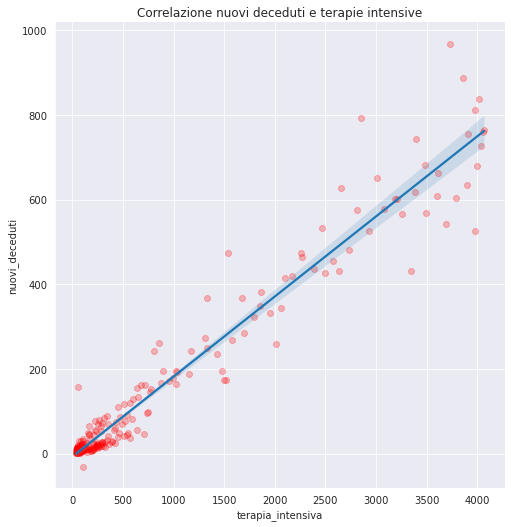

In [14]:
g = sns.lmplot(
    data=df,
    x='terapia_intensiva', y='nuovi_deceduti',
    x_jitter=.3, y_jitter=.3,
    order=1,
    height=7,
    scatter_kws={'alpha':.25, 'color':'r'}
)
g.set(
    title='Correlazione nuovi deceduti e terapie intensive'
)
plt.show()

In [15]:
model = sm.OLS.from_formula('nuovi_deceduti ~ terapia_intensiva', data=df)
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         nuovi_deceduti   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     4434.
Date:                Sat, 17 Oct 2020   Prob (F-statistic):          4.40e-154
Time:                        16:56:08   Log-Likelihood:                -1262.5
No. Observations:                 236   AIC:                             2529.
Df Residuals:                     234   BIC:                             2536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -6.7783      4.118     -1.646      0.101     -14.891       1.335
terapia_intensiva     0.1891      0.003     66.585      0.000       0.184       0.195
==============================================================================
Omnibus:                       80.483   Durbin-Watson:                   1.234
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              801.048
Skew:                           1.010   Prob(JB):                    1.13e-174
Kurtosis:                      11.797   Cond. No.                     1.79e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
fit_res = {}
grouped = df.groupby('mese_num')
for mese in grouped:
    fit_res.update({mese[0]: {}})
    _df = mese[1][['nuovi_deceduti', 'terapia_intensiva']]
    model = sm.OLS.from_formula('nuovi_deceduti ~ terapia_intensiva', data=_df[1:])
    results = model.fit()
    fit_res[mese[0]]['R2'] = results.rsquared
    fit_res[mese[0]]['Intercept'] = results.params.Intercept
    fit_res[mese[0]]['coefficient'] = results.params.terapia_intensiva

Correlazione nuovi deceduti e terapie intensive per mese:

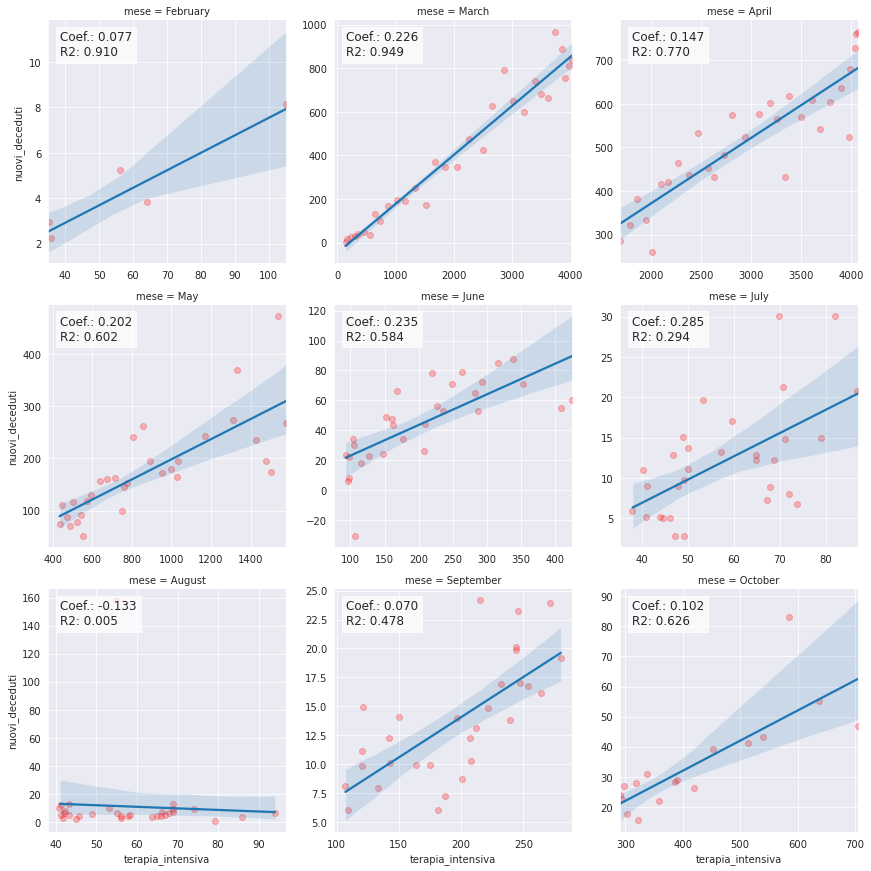

In [17]:
g = sns.lmplot(
    data=df,
    x='terapia_intensiva', y='nuovi_deceduti',
    x_jitter=.3, y_jitter=.3,
    order=1,
    height=4, col='mese', col_wrap=3,
    sharex=False, sharey=False,
    scatter_kws={'alpha':.25, 'color':'r'}
)
for i, res in enumerate(fit_res):
    xlim = g.axes.flat[i].get_xlim()
    ylim = g.axes.flat[i].get_ylim()
    g.axes.flat[i].text(
        0.05, 0.9,
        f"Coef.: {fit_res[res]['coefficient']:.3f}\nR2: {fit_res[res]['R2']:.3f}",
        ha='left', va='center', fontsize=12,
        transform=g.axes.flat[i].transAxes,
        bbox=dict(facecolor='w', alpha=0.75)
    )